# 1 Análise Exploratória de Dados - EDA

Neste notebook, vamos fazer algumas análises exploratórias de dados. 

Vamos fundamentalmente carregar os dados realizar os tratamentos mínimos necessários para obter uma base de dados para nossa modelagem.

O foco vai ser no tratamento de dados, não na análise de dados, e assim vamos remover os dados nulos e através de algumas ferramentas estatísticas, vamos selecionar as variáveis mais relevantes para nossa modelagem.

## 1.0 Preparando o ambiente

Carregando as bibliotecas necessárias para o EDA.

In [1]:
import pickle
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest

#Ignorar warning
import warnings
warnings.filterwarnings("ignore")

## 1.1 Levantamento das informações sobre as variáveis

Segue a relação das variaveis e suas descrições, de acordo com o empresa Vesta responsável pelos dados:

* Indentity table (Tabela de identidade do usuário):
    * Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions. They're collected by Vesta’s fraud protection system and digital security partners. (The field names are masked and pairwise dictionary will not be provided for privacy protection and contract agreement)

    * Categorical Features:
        * DeviceType
        * DeviceInfo
        * id_12 - id_38

* Transaction table (Tabela de transações):
    * TransactionID: identificação da transação.
    * isFraud: identifica se a transação é fraudulenta ou não.(0 ou 1) Apenas no conjunto de treinamento.
    * TransactionDT: data e hora da transação em um referência desconhecida.
    * TransactionAmt: valor de transação de saque.
    * ProductCD: produto da transação. (contem o código do produto, são apenas 5 categorias)
    * card1 - card6: informação do cartão de pagamento, como tipo do cartão, categoria do cartão, banco emitente, pais, etc.
    * addr1, addr2: informação de endereço
    * dist1, dist2,: distância
    * id12 to id13 variáveis numéricas para identificar a transação.
    * P_ and (R__) emaildomain: purchaser and recipient email domain
    * D1-D15: timedelta, such as days between previous transaction, etc.
    * M1-M9: match, such as names on card and address, etc.
    * V1 to V340 são variáveis numéricas criadas pela Vesta.
    * Variáveis categoricas:
        * ProductCD
        * card1 - card6
        * addr1, addr2
        * P_emaildomain
        * R_emaildomain 
        * M1 - M9    


In [2]:
df_train_id = pd.read_csv('./ieee-fraud-detection/train_identity.csv')
df_train_transaction = pd.read_csv('./ieee-fraud-detection/train_transaction.csv')
df_test_id = pd.read_csv('./ieee-fraud-detection/test_identity.csv')
df_test_transaction = pd.read_csv('./ieee-fraud-detection/test_transaction.csv')

In [3]:
# Agrupando os dado de train_transaction e train_identity
# Dataframe de treino
X_train = df_train_transaction.merge(df_train_id, how='left', left_index=True, right_index=True) 

# Variável target
y_train = X_train['isFraud'].copy()

# Dataframe de test
fix = {o:n for o, n in zip(df_test_id.columns, df_train_id.columns)} # Adequação das colunas do test_id
df_test_id.rename(columns=fix, inplace=True)
X_test = df_test_transaction.merge(df_test_id, how='left', left_index=True, right_index=True)

# Limpeza da memória para melhorar performance
del df_train_id, df_train_transaction, df_test_transaction,df_test_id, X_train['isFraud'];  x = gc.collect()

# PRINT STATUS
print('Train shape',X_train.shape,'test shape',X_test.shape)

Train shape (590540, 434) test shape (506691, 434)


Temos um total de 434 variáveis, sendo que dessas 31 são strings e as demais numéricas. Sendo que das variáveis numéricas 340 são variáveis criadas pela Vesta, dessa forma o conjunto de dados original tem 95 variáveis. 

In [4]:
print('Variável Target - Train')
y_count = pd.DataFrame()
y_count['Contagem'] = y_train.value_counts()#.rename({'index':'Value','axis':'Contagem'})
y_count['Porcentagem'] = np.round(y_count / y_count.sum(), 4)*100
y_count.index.name = 'Valor'
y_count

Variável Target - Train


,Contagem,Porcentagem
Valor,,
0,569877,96.5
1,20663,3.5


Observamos que o conjunto de dados é bem desbalanceado com cerca de 3,5% de fraudes. Isso pode impactar significativamente nosso processo de modelagem e devemos estar atentos ao desbalanceamento na escolha do nosso modelo.

O desbalanceamento é muito comum de ocorrer em conjunto de dados que tentam prever anomalias, como por exemplo, classificação de spam.

## 1.2 Seleção das variáveis

Como mencionado temos 340 variáveis numéricas que a Vetra criou nos demais dados de transações. Sendo assim pode ser que algumas dessa variáveis sejam fortemente correlacionadas com as outras e isso pode prejudicar nosso modelo. Assim é pertinente realizar uma análise exploratória para verificar se existe alguma correlação entre as variáveis para selecionar as variáveis com menor número de nan's.

Conforme apresentado no [Towards Data Science](https://towardsdatascience.com/learn-how-to-do-feature-selection-the-right-way-61bca8557bef) iremos realizar teste para cada categoria de variáveis para selecionar as que estatiscamente fazem mais sentido para o nosso problema de classificação.

 <img src=https://miro.medium.com/max/700/1*tzfWABEHK9-4SOaSl1mdRA.png />

 No nosso projeto temos como variáveis de entrada tanto variáveis categóricas e variáveis numéricas e nossa variável de saída é uma variável categórica. Assim, conforme o diagrama acima para selecionar nossas variáveis mais relevantes vamos utilizar o coeficiente de correlação de Kendall e Anova para selecionar as variáveis que possuem maior correlação.

## 1.3 Definição de estratégia de análise

Optamos por não apresentar gráfico referente as variáveis no processo de EDA, pois isso foi muito bem feito por [Alij's](https://www.kaggle.com/code/alijs1/ieee-transaction-columns-reference/notebook) e não vemos como essa exploração pode ser melhorada. 

Vamos realizar uma seleção automatizada das variáveis numéricas, para que possamos verificar se as mesmas são relevantes para a análise em especial as varíaveis criadas pela Vesta, pois são muitas. Vamos adotar para isso dois critérios:

* Variáveis numéricas:
    * Correlação de Kendall entre as variáveis. *(Ver observação abaixo)*
    * Teste ANOVA 
* Variáveis categóricas:
    * Mutual information
    * Chi-square

Observação:	A correlação de Kendall poderia ser aplicada tanto para as variáveis categoricas e numéricas, mas vamos aplicar apenas para as variáveis numéricas, pois dentro das variáveis numéricas existem dados com características categóricas. Para a selação das variáveis categóricas, vamos utilizar a função [mutual_info_classif](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html) que calcula a informação mutuária entre duas variáveis e a função [Chi-squared](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html) mede a dependência entre duas variáveis estocásticas.

### 1.3.2 Normalização dos dados de tempo

Conforme exposto acima as Colunas D são "deltas de tempo" de algum ponto no passado. Vamos transformar as Colunas D em seu ponto no passado. Isso impedirá que as colunas D aumentem com o tempo. A fórmula é `D15n = Transaction_Day - D15` e `Transaction_Day = TransactionDT/(24*60*60)`. Depois, multiplicamos esse número por menos um.

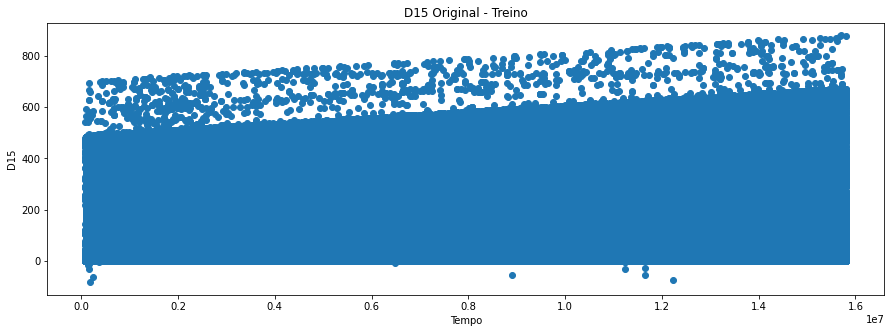

In [5]:
# Dados originais
plt.figure(figsize=(15,5))
plt.scatter(X_train['TransactionDT'],X_train['D15'])
plt.title('D15 Original - Treino')
plt.xlabel('Tempo')
plt.ylabel('D15')
plt.show()

In [6]:
for i in range(1,16):
    if i in [1,2,3,5,9]: continue
    X_train['D'+str(i)] =  X_train['D'+str(i)] - X_train.TransactionDT/np.float32(24*60*60)
    X_test['D'+str(i)] = X_test['D'+str(i)] - X_test.TransactionDT/np.float32(24*60*60) 

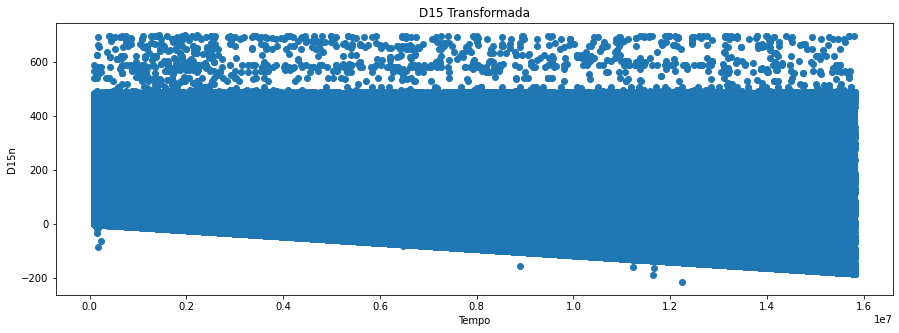

In [7]:
# PLOT TRANSFORMED D
plt.figure(figsize=(15,5))
plt.scatter(X_train['TransactionDT'],X_train['D15'])
plt.title('D15 Transformada')
plt.xlabel('Tempo')
plt.ylabel('D15n')
plt.show()

In [8]:
# Montamos a lista das variáveis categóricas
# Conforme identificamos no kaggle nas discussões sobre as variáveis
# As variáveis categóricas que já estão no formato inteiro são:
# 'addr1', 'addr2', 'id_32' 
# Obs.:dever ser algum mascaramento para preservar os usuários sendo 
# esta informação ser possivelmente sensível 

lista_var_categoricas = ['DeviceType','DeviceInfo','ProductCD','card4','card6','M4',
                         'P_emaildomain','R_emaildomain','addr1','addr2','M1','M2','M3',
                         'M5','M6','M7','M8','M9','id_12','id_15','id_16','id_23','id_27',
                         'id_28','id_29','id_30','id_31','id_32','id_33','id_34','id_35',
                         'id_36','id_37','id_38']


In [9]:
%%time
X_train_clean = pd.DataFrame()
X_test_clean = pd.DataFrame()
# Redução de uso de memória e processamento do label encode
# Preenchendo os valores nulos com -1
for i,col in enumerate(X_train.columns):
    # FACTORIZE CATEGORICAL VARIABLES
    if (np.str(X_train[col].dtype)=='category')|(X_train[col].dtype=='object'): 
        df_comb = pd.concat([X_train[col],X_test[col]],axis=0)
        df_comb,_ = df_comb.factorize(sort=True)
        if df_comb.max()>32000: print(col,'needs int32')
        X_train_clean[col] = df_comb[:len(X_train)].astype('int16')
        X_test_clean[col] = df_comb[len(X_train):].astype('int16')
        
    # Deslocamento dos dados numéricos para serem positivos
    # Preenchendo os valores nulos com -1
    # 'TransactionAmt' 'TransactionDT' essas variáveis são positivas 
    # e não precisam ser tratadas
    elif col not in ['TransactionAmt','TransactionDT','addr1','addr2','id_32']: 
        mn = np.min((X_train[col].min(),X_test[col].min()))
        X_train[col] -= np.float32(mn)
        X_test[col] -= np.float32(mn)
        X_train_clean[col] = X_train[col].fillna(-1)
        X_test_clean[col] = X_test[col].fillna(-1)

for i in ['TransactionAmt','TransactionDT','addr1','addr2','id_32']:
    X_train_clean[i] = X_train[i].fillna(-1)
    X_test_clean[i] = X_test[i].fillna(-1)

# Limpeza da memória para melhorar performance    
del df_comb,X_test; x = gc.collect()

CPU times: total: 1min 45s
Wall time: 1min 45s


In [10]:
# lista das variáveis numéricas
lista_var_num = list((set(X_train.columns) - set(lista_var_categoricas)))
# Proporção das variáveis numéricas
print(f'A proporçção das variáveis numéricas é: {len(lista_var_num)/len(X_train.columns)*100:.2f}%')

A proporçção das variáveis numéricas é: 92.17%


## 1.4 Seleção estatística das variáveis numéricas

In [11]:
%%time
############################################################################# 
### Selecionando as variáveis as variáveis numéricas ########################
#############################################################################


# Correlação entre as colunas das variáveis numéricas
# Conforme o artigo do acima vamos usar o método de Kendall para calcular a correlação
# pois estamos trabalhando uma saída do tipo categorica.
corr_matrix = X_train_clean[lista_var_num].corr(method='kendall')

#Obs.: essa célula demora muito tempo (~75 minutos) para ser executada,
# usea com sabedoria 

CPU times: total: 1h 11min 24s
Wall time: 1h 11min 30s


In [32]:
# Nesse ponto estamos verificar as variáveis que possuem correlação entre si 
# superior ao trheshold de 0.9. 

# Correlação maxima que iremos permitir para as variáveis numéricas
mask = (corr_matrix.abs()<.9) # Obs.: Usamos o método abs para considerar os valores negativos

In [24]:
# Soma dos nan's variáveis numericas (NAN = -1)
var_nan =  (X_train_clean[lista_var_num] == -1).sum()

In [35]:
# Monta a lista das variáveis que apresentam um fator de correlação entre si
# superior ao theshold estabelecido

corr_selection = []
# Vamos o triangulo abaixo da diagonal da matriz de correlação
for i, col in enumerate(mask.columns):
    for j, ind in enumerate(mask.index):
        if i < j and mask.iloc[i,j] == False:
            list_aux = [x for x in mask[mask[col] == False].index.values]
            list_aux.insert(0,col)
    # Entre as duas variáveis, a correlação é superior ao threshold
    # tomaremos a que tem o menor número de nans
    var_aux = var_nan[list_aux].idxmin()
    if var_aux not in corr_selection:
        corr_selection.append(var_aux)
            
            
# Resultado
print(f'A lista das variáveis de variáveis numericas selecionadas é: {len(corr_selection)}')
print(f'A lista das variáveis que apresentam correlação entre si superior ao threshold é: {corr_selection}')


A lista das variáveis de variáveis numericas selecionadas é: 108
A lista das variáveis que apresentam correlação entre si superior ao threshold é: ['V68', 'C10', 'V135', 'V22', 'V21', 'V297', 'V284', 'V3', 'V102', 'V48', 'V54', 'id_22', 'TransactionDT', 'V127', 'V304', 'V56', 'V321', 'V20', 'V41', 'V76', 'V280', 'V34', 'V128', 'V81', 'V17', 'V14', 'V66', 'V77', 'V306', 'V26', 'V31', 'id_11', 'V316', 'V86', 'V16', 'V295', 'V27', 'V64', 'TransactionID_y', 'V84', 'V104', 'C8', 'V88', 'V119', 'V283', 'V60', 'V43', 'V93', 'id_10', 'V50', 'V94', 'V7', 'V311', 'V46', 'id_01', 'V71', 'V29', 'V98', 'V134', 'V92', 'V289', 'V300', 'V130', 'V52', 'V132', 'V131', 'V30', 'V313', 'V9', 'V10', 'D9', 'V72', 'V8', 'V82', 'V38', 'V320', 'V33', 'V95', 'V18', 'V23', 'V42', 'V106', 'V312', 'V28', 'D6', 'V105', 'V315', 'V36', 'C7', 'V44', 'V32', 'V61', 'V51', 'V63', 'D1', 'V37', 'V45', 'V85', 'V294', 'V13', 'V1', 'V59', 'V6', 'V5', 'V15', 'V2', 'V40', 'V80']


### 1.4.1 Teste ANOVA

A aplicação do teste ANOVA é feita para selecionar as variáveis e ela verifica se a relação de cada variável (continua ou não) com a saída é significativa. Para isso ela verifica se a variância dos grupos  é significativa para saber se a variável pode ser considerada no modelo de treino. Para maiores detalhes sobre este teste veja [aqui](https://towardsdatascience.com/anova-for-feature-selection-in-machine-learning-d9305e228476) e [aqui](https://towardsdatascience.com/statistics-in-python-using-anova-for-feature-selection-b4dc876ef4f0)

In [36]:
# Teste ANOVA para selecionar as variáveis 
selector_anova = SelectKBest(f_classif, k='all')
selector_anova.fit_transform(X_train_clean[lista_var_num], y_train)
anova_feature = selector_anova.get_feature_names_out()
anova_support = selector_anova.pvalues_

# Vamos selecionar as variáveis com o p-value igual 0
anova_selection = []
for i,k in enumerate(anova_support):
    if k == 0:
        anova_selection.append(anova_feature[i])

# limpando os dados
del selector_anova,anova_feature,anova_support; x = gc.collect()

print(f'A quantidade de variáveis selecionadas pelo ANOVA é: {len(anova_selection)}')
print(anova_selection)

A quantidade de variáveis selecionadas pelo ANOVA é: 177
['V257', 'V249', 'V22', 'V21', 'V148', 'V3', 'V48', 'V54', 'V34', 'V81', 'V217', 'card3', 'V169', 'V17', 'V219', 'V227', 'V253', 'V242', 'V77', 'V260', 'V251', 'V228', 'V31', 'V86', 'V16', 'V87', 'V244', 'V196', 'V175', 'V64', 'V259', 'V157', 'V192', 'V84', 'V235', 'V114', 'V256', 'V239', 'V171', 'D11', 'V112', 'V283', 'V60', 'V49', 'V43', 'V229', 'V93', 'V149', 'V246', 'D15', 'V191', 'V230', 'V198', 'V53', 'V50', 'V94', 'V241', 'V115', 'V140', 'V255', 'V58', 'D14', 'V7', 'V236', 'V304', 'V110', 'V181', 'V139', 'V302', 'V71', 'V29', 'V116', 'V92', 'V124', 'V247', 'V52', 'V173', 'V185', 'V91', 'V9', 'V10', 'V188', 'D9', 'V72', 'V197', 'V8', 'V38', 'V78', 'V73', 'V18', 'V248', 'V70', 'V262', 'V225', 'V146', 'V42', 'D13', 'V233', 'V125', 'V57', 'V176', 'V237', 'V221', 'D6', 'V172', 'V254', 'V195', 'D12', 'V240', 'V44', 'V32', 'V250', 'V238', 'V51', 'V63', 'V282', 'D1', 'V174', 'V37', 'V186', 'V218', 'V193', 'V158', 'V281', 'V109', '

In [37]:
# Reunindo o conjunto das variáveis selecionadas pelo teste de Chi-squared e 
# o teste de mutual information
conj_final_var_num = list(set(corr_selection).intersection(set(anova_selection)))

print(f'A quantidade de variáveis *numéricas* selecionadas é: {len(conj_final_var_num)}')
print('São elas: ',conj_final_var_num)

A quantidade de variáveis *numéricas* selecionadas é: 54
São elas:  ['V38', 'V92', 'V43', 'V18', 'V22', 'V21', 'V15', 'V93', 'V42', 'V3', 'V2', 'V31', 'V86', 'V45', 'V48', 'V54', 'V16', 'V50', 'V52', 'V94', 'V85', 'V40', 'D6', 'V64', 'V34', 'V7', 'V81', 'V84', 'V304', 'V33', 'V17', 'V13', 'V9', 'V10', 'V1', 'V44', 'V32', 'V59', 'D9', 'V72', 'V6', 'V77', 'V80', 'V8', 'V51', 'V71', 'V29', 'V30', 'V63', 'V5', 'V283', 'V60', 'V37', 'D1']


## 1.5 Seleção estatística das variáveis categóricas

Vamos selecionar as variáveis categoricas através da intersecção do conjunto de váriaveis numéricas que foram selecionadas pelo teste de correlação de Kendall e pelo teste ANOVA.

**Observação:** estamos adotando uma postura conservadora em relação a seleção de variáveis para tentar reduzir o número de variáveis. Isso irá nos permitir dispender menos tempo no treinamento, avaliação e otimização do modelo.

In [38]:
############################################################################### 
### Selecionando as variáveis as variáveis categoricas ########################
###############################################################################

# Teste de Chi-squared para selecionar as variáveis com o melhor score
# Para o teste Chi-squared temos que usar dados sem valores negativos,
# ou seja, o conjunto de dados sem o preenchimento de valores nulos por -1
for col in lista_var_categoricas:
    X_train[col],_ = X_train[col].factorize(sort=True,na_sentinel=None)

# Teste de Chi-squared para selecionar as variáveis com o melhor score
selector_chi2 = SelectKBest(chi2, k='all')
selector_chi2.fit_transform(X_train[lista_var_categoricas], y_train)
chi_feature = selector_chi2.get_feature_names_out()
chi_support = selector_chi2.pvalues_

# Vamos selecionar as variáveis com o p-value maior que 0
chi_selection = []
for i,k in enumerate(chi_support):
    if k == 0:
        chi_selection.append(chi_feature[i])

print(f'A quantidade de variáveis selecionadas pelo Chi-squared é: {len(chi_selection)}')
print(chi_selection)

A quantidade de variáveis selecionadas pelo Chi-squared é: 10
['DeviceInfo', 'ProductCD', 'P_emaildomain', 'R_emaildomain', 'addr1', 'addr2', 'M6', 'M7', 'id_31', 'id_33']


In [39]:
selector_mi = SelectKBest(mutual_info_classif, k='all')
selector_mi.fit(X_train[lista_var_categoricas], y_train)
mi_selection = selector_mi.get_feature_names_out()
# Vamos selecionar as 17 variáveis com o melhor score
# Esse teste não apresentou um threshold para selecionar as variáveis
# Se obtou por escolher 2/3 das variáveis com o melhor score
mi_selection = pd.Series(selector_mi.scores_, index=selector_mi.get_feature_names_out()).nlargest(2*(len(lista_var_categoricas)//3)).index.values
mi_selection = list(mi_selection)

print(f'A quantidade de variáveis selecionadas pelo teste da informação mutual é: {len(mi_selection)}')
print(mi_selection)

A quantidade de variáveis selecionadas pelo teste da informação mutual é: 22
['id_33', 'id_27', 'id_30', 'id_23', 'id_31', 'id_32', 'id_34', 'ProductCD', 'id_36', 'id_16', 'DeviceType', 'id_29', 'id_28', 'id_38', 'card6', 'id_35', 'id_37', 'id_12', 'id_15', 'addr2', 'R_emaildomain', 'M7']


Vamos selecionar as variáveis categoricas através da intersecção do conjunto de váriaveis que foram selecionadas pelo teste Chi-square e pelo teste de Mutual Information.

**Observação:** estamos adotando uma postura conservadora em relação a seleção de variáveis para tentar reduzir o número de variáveis. Isso irá nos permitir dispender menos tempo no treinamento, avaliação e otimização do modelo.

In [40]:
# Reunindo o conjunto das variáveis selecionadas pelo teste de Chi-squared e 
# o teste de mutual information
conj_final_var_cat = list(set(mi_selection).intersection(set(chi_selection)))

print(f'A quantidade de variáveis categoricas selecionadas é: {len(conj_final_var_cat)}')
print('São elas: ',conj_final_var_cat)

A quantidade de variáveis categoricas selecionadas é: 6
São elas:  ['R_emaildomain', 'id_33', 'addr2', 'M7', 'id_31', 'ProductCD']


In [41]:
final_vars_selection = conj_final_var_num + conj_final_var_cat

print(f'Quantidade final de seleção das nossas variáveis: {len(final_vars_selection)}')


Quantidade final de seleção das nossas variáveis: 60


## 1.6  Salvando dados para o próximo passo

In [42]:
# Criando os dataframes com as variáveis selecionadas
X_test_clean = X_test_clean[final_vars_selection]
X_train_clean = X_train_clean[final_vars_selection]

In [43]:
# Salvando os dataframes com as variáveis selecionadas
# para serem utilizadas para a etapa de modelagem de ML
with open('./ieee-fraud-detection/X.train', 'wb') as Xtrain:
    pickle.dump(X_train_clean, Xtrain, pickle.HIGHEST_PROTOCOL)
    
with open('./ieee-fraud-detection/X.test', 'wb') as Xtest:
    pickle.dump(X_test_clean, Xtest, pickle.HIGHEST_PROTOCOL)

with open('./ieee-fraud-detection/Y.train', 'wb') as Ytrain:
    pickle.dump(y_train, Ytrain, pickle.HIGHEST_PROTOCOL)


## 1.7 Conclusões e recomendações - EDA

Realizamos nessa etapa a exploração dos dados e a seleção das variáveis. 

Neste trabalho o foco foi dado no processo de seleção das variáveis.

Adotamos um critério de seleção de variáveis para o modelo de classificação bem restritivo para obter apenas a variáveis mais significativas possiveis para o modelo.

Há diversos pontos deste trabalho que poderiam ser melhorados de forma a obter as variáveis para melhorar a performance do modelo. Como por exemplo, aplicação do teste de correlação para todo o conjunto de dados, seleção de variáveis utilizando quartis, etc.

